In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import make_country_mask
import xarray as xr
import numpy as np
import clustering_sklearn as cl
import utils
import plotting
path_obs_data = '/data/volume_2/observational/'
filename = 'chrips_precip_1981-2021.nc'
path_tp = os.path.join(path_obs_data, 'preprocessed', 'chrips_precip_1981-2021_africa_aggregated_intervals.nc')

In [2]:
# ds_EC46 = xr.open_dataset('/data/volume_2/subseasonal/ecmwf/hindcast/ecmwf-hindcast-tp-20010618.nc')
# ds_EC46 = ds_EC46.isel(realization=0, lead_time=0, forecast_time=0)
# ds_EC46 = utils.formatting_ds(ds_EC46, format_lon='west_east')
# ds_EC46 = utils.get_selbox(ds_EC46, selbox=(10, 60, -30, 30))
# mask_xr, df_names = make_country_mask.create_mask(tp, level='Countries')
# hoa_countries = ['Kenya', 'Ethiopia', 'Uganda', 'Somalia']
# df_hoa = df_names[(df_names['abbrev']=='KE') | (df_names['abbrev']=='ET') | \
#                   (df_names['abbrev']=='UG') | (df_names['abbrev']=='SO')]
# df_hoa
# # create a Horn of Africa (hoa) mask
# hoa_mask = utils.view_or_replace_labels(mask_xr, regions=df_hoa['label'].values.astype(int))
# hoa_mask.plot()

Open dataset, align format, select OND months 

In [21]:
tp = xr.open_dataarray(path_tp)
# calender = time.AdventCalendar(anchor_date=(1,1), freq='1M')

# keep_months = [10,11,12]
# mask = [True if m in keep_months else False for m in tp.time.dt.month]
# tp = tp.where(np.array(mask)[:,None,None]).dropna(dim='time')

In [22]:
path_tp

'/data/volume_2/observational/preprocessed/chrips_precip_1981-2021_africa_aggregated_intervals.nc'

Calculate mean over OND months

In [23]:
tp_OND = tp.groupby(tp.anchor_year).mean(dim='target_period')

In [24]:
mask_xr, df_names = make_country_mask.create_mask(tp_OND[0], level='Countries')

hoa_countries = ['Kenya', 'Ethiopia', 'Uganda', 'Somalia']
df_hoa = df_names[(df_names['abbrev']=='KE') | (df_names['abbrev']=='ET') | \
                  (df_names['abbrev']=='UG') | (df_names['abbrev']=='SO')]
df_hoa

Creating Country Mask:    5688/   5688 (100.0%)


,name,abbrev,label
69,Ethiopia,ET,69
115,Kenya,KE,115
206,Somalia,SO,206
231,Uganda,UG,231


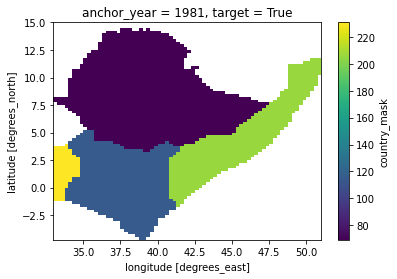

In [25]:
# create a Horn of Africa (hoa) mask
hoa_mask = utils.view_or_replace_labels(mask_xr, regions=df_hoa['label'].values.astype(int))
hoa_mask.plot()

Plotting Corr maps precip, split 0, lag 0
Plotting Corr maps precip, split 0, lag 0


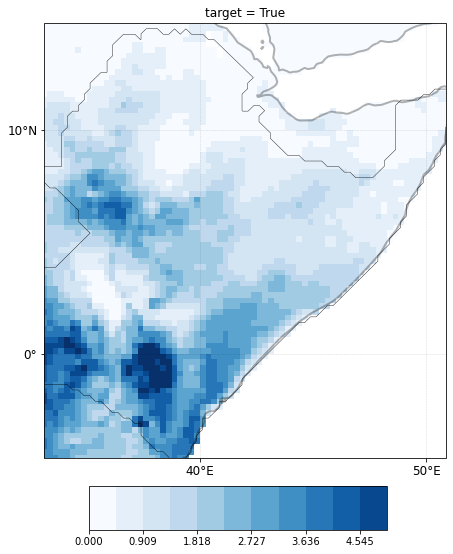

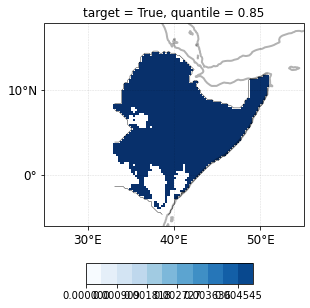

In [37]:
# climatoligical mean of OND rainfall
plotting.plot_maps(tp.mean(dim=('anchor_year', 'target_period')), mask_xr=~np.isnan(hoa_mask), 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5, 12))

# Keeping 85% of most dry gridcells in HoA
tp_hoa_OND = tp_OND.where(~np.isnan(hoa_mask).values)
mask_wet_regions = tp_hoa_OND.mean(dim=('anchor_year')) < tp_hoa_OND.quantile(.85)
tp_hoa_OND_dry = tp_OND.where(mask_wet_regions)
fg = plotting.plot_maps(tp_hoa_OND_dry.mean(dim=('anchor_year')), mask_xr=~np.isnan(hoa_mask), 
                       size=4, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12), zoomregion=(25,55,-6,18))

Create weight file: bilinear_221x241_37x40.nc


/home/svijverber/miniconda3/envs/test_env/lib/python3.10/site-packages/xesmf/frontend.py:412: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Remove file bilinear_221x241_37x40.nc
Plotting Corr maps tp, split 0, lag 0


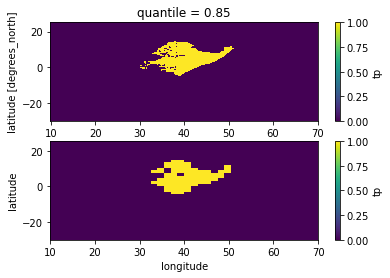

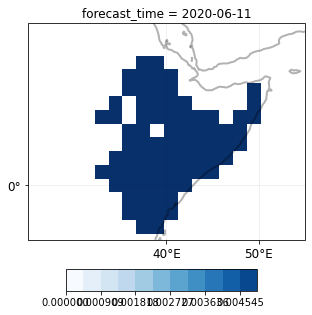

In [67]:
f, axs = plt.subplots(2)
mask_wet_regions.plot(ax=axs[0])
mask_wet_regions.to_netcdf('/data/volume_2/observational/chirps_hoa_dry_mask_0.25deg.nc')
mask_EC46_res = utils.regrid_xarray(mask_wet_regions, 1.5, periodic=False) # regrid to 1.5 degrees
mask_EC46_res.plot(ax=axs[1])
mask_EC46_res.to_netcdf('/data/volume_2/subseasonal/chirps_hoa_dry_mask_1.5deg.nc')
ds_EC46 = xr.open_dataset('/data/volume_2/subseasonal/ecmwf/forecast/ecmwf-forecast-tp-20200611.nc')['tp']
ds_EC46lonlat = ds_EC46.isel(forecast_time=0).mean(dim=('realization', 'lead_time'))
ds_EC46lonlat = utils.get_selbox(ds_EC46lonlat, selbox=(10, 70, -30, 25))
fg = plotting.plot_maps(ds_EC46lonlat.where(mask_EC46_res.values), 
                       size=4, cbar_vert=-0.1, cmap=plt.cm.Blues,  clevels=np.linspace(0, 5E-3, 12), zoomregion=(25,55,-6,18))

          Ethiopia     Kenya   Somalia    Uganda
Ethiopia  1.000000  0.668676  0.640644  0.777784
Kenya     0.668676  1.000000  0.862768  0.780025
Somalia   0.640644  0.862768  1.000000  0.649853
Uganda    0.777784  0.780025  0.649853  1.000000


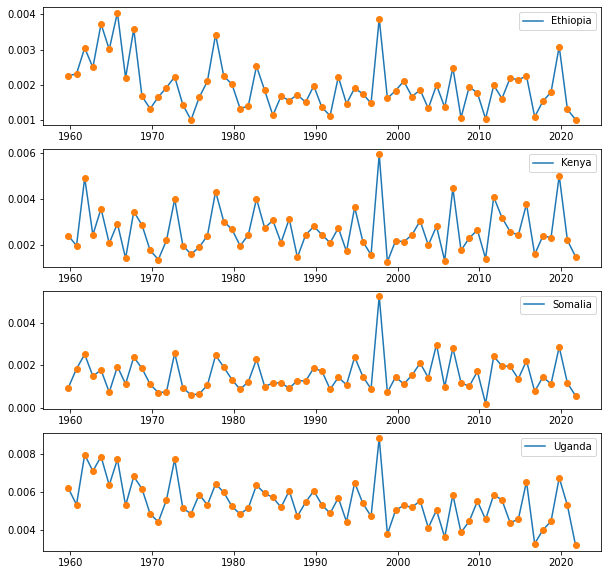

In [13]:
country_labels = np.unique(hoa_mask)[:-1].astype(int)
fig, axes = plt.subplots(len(country_labels), figsize=(10,10))
dfs = []
for i, label in enumerate(country_labels):
    tp_country = tp_hoa_OND.where(hoa_mask.values==label).mean(dim=('latitude', 'longitude'))
    country_name = df_hoa[df_hoa['label'].astype(int)==label]['name'].values[0]
    axes[i].plot(utils.pd.to_datetime(tp_country.time.values), tp_country.values, label=country_name)
    axes[i].plot_date(x=utils.pd.to_datetime(tp_country.time.values), y=tp_country, label=None)
    axes[i].legend()
    dfs.append(tp_country.to_dataframe(name=country_name))
print(pd.concat(dfs, axis=1).corr())

In [14]:
tp_hoa = tp_OND.where(~np.isnan(hoa_mask))

Plotting Corr maps tp, split 0, lag 0


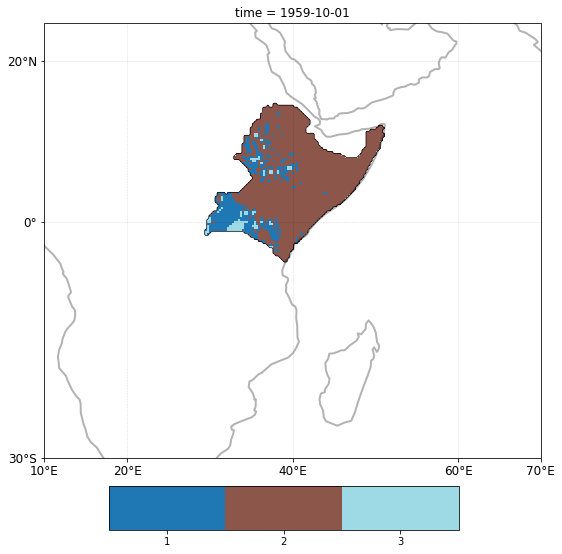

In [15]:
n_clusters = 3
xrclustered, algorithm = cl.skclustering(tp_hoa, spatial_mask=~np.isnan(hoa_mask), 
                                         clustermethodkey = 'KMeans',
                                         kwrgs = {'n_clusters': n_clusters},
                                         dimension='spatial')

plotting.plot_labels(xrclustered,   
                     kwrgs_plot={'size':8, 'cbar_vert':-0.1, 'mask_xr':~np.isnan(hoa_mask)} )

Plotting Corr maps tp, split 0, cluster 1
Plotting Corr maps tp, split 0, cluster 2


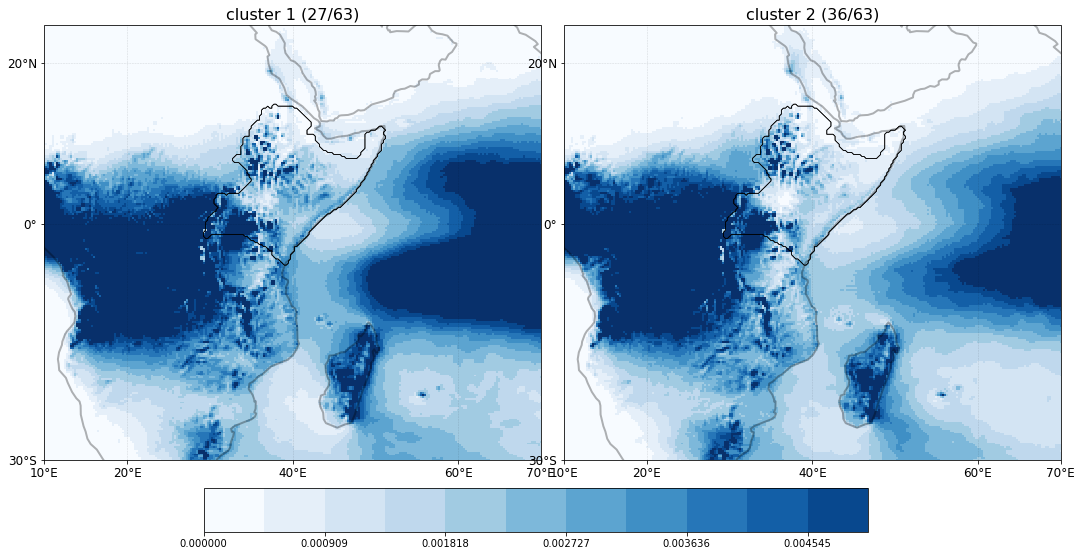

In [16]:
xrclustered, algorithm = cl.skclustering(tp_OND, spatial_mask=None, 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 2, 'affinity':'correlation', 'linkage':'complete'},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))

plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

Plotting Corr maps tp, split 0, cluster 1
Plotting Corr maps tp, split 0, cluster 2


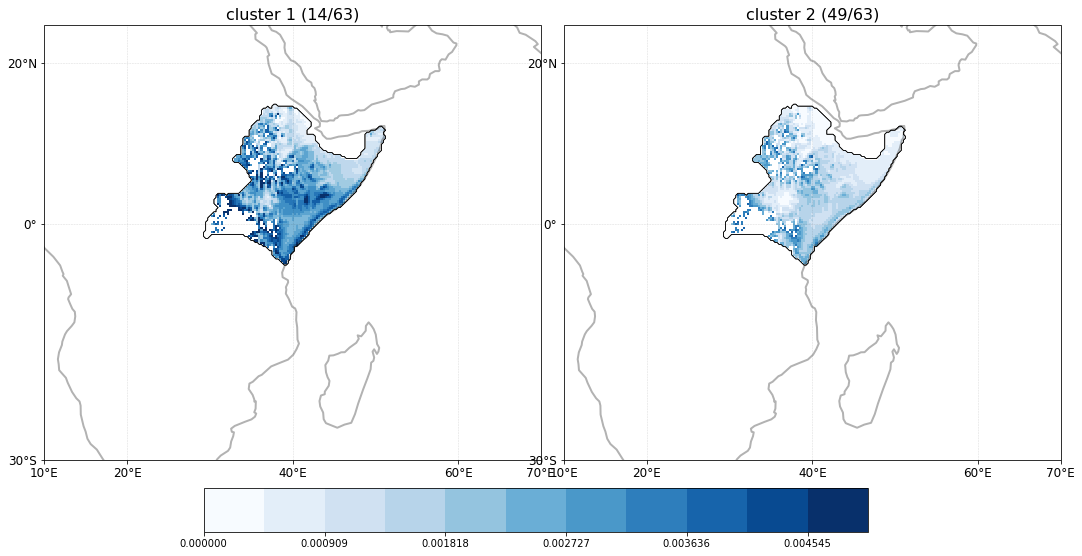

In [17]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(mask_wet_regions), spatial_mask=None, 
                                         clustermethodkey = 'KMeans',
                                         kwrgs = {'n_clusters': 2},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

Plotting Corr maps tp, split 0, cluster 1
Plotting Corr maps tp, split 0, cluster 2


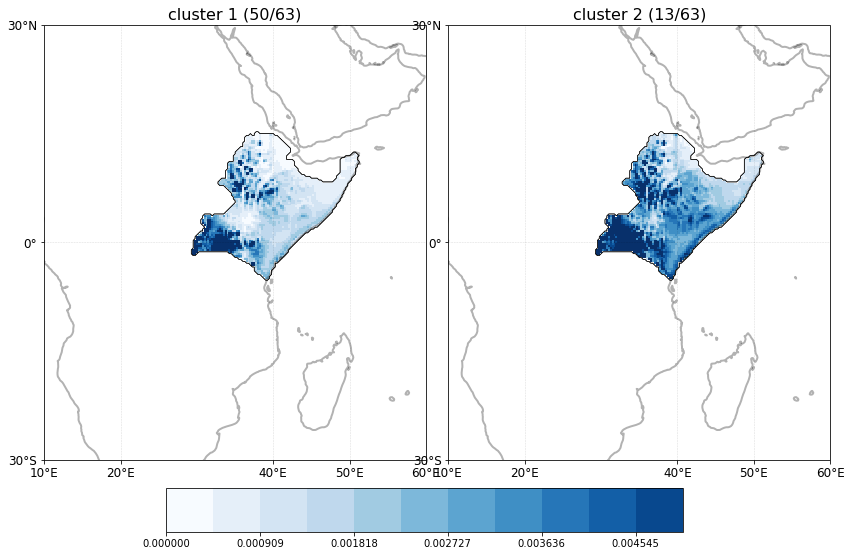

In [47]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(~np.isnan(hoa_mask).values), spatial_mask=None, 
                                         clustermethodkey = 'KMeans',
                                         kwrgs = {'n_clusters': 2},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

Plotting Corr maps tp, split 0, cluster 1
Plotting Corr maps tp, split 0, cluster 2


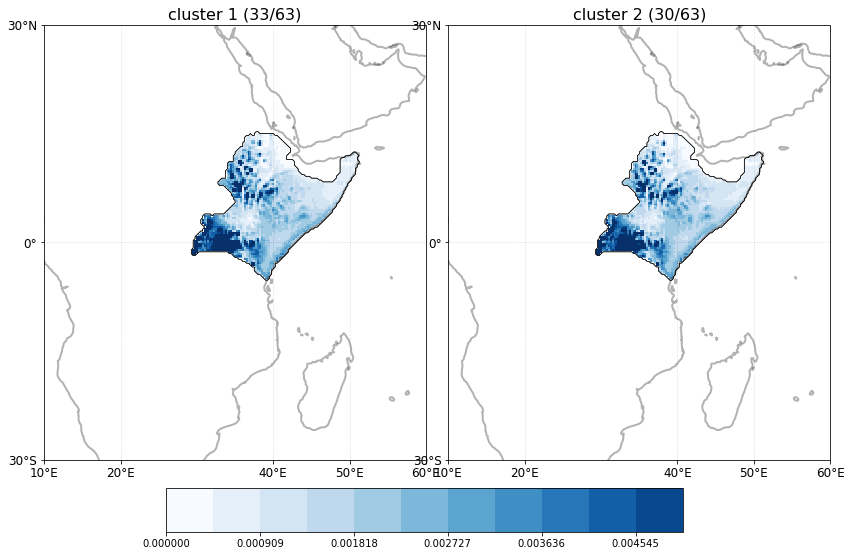

In [46]:
xrclustered, algorithm = cl.skclustering(tp_OND.where(~np.isnan(hoa_mask).values), spatial_mask=None, 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 2, 'affinity':'correlation', 'linkage':'complete'},
                                         dimension='temporal')
percentages = [f"cluster {c} ({int((xrclustered['cluster']==c).sum())}/{int(xrclustered['cluster'].size)})" for c in np.unique(xrclustered['cluster'])]
hoa_mask_cl = xr.concat([~np.isnan(hoa_mask)]*len(np.unique(xrclustered.cluster.values)), dim='cluster')
hoa_mask_cl['cluster'] = ('cluster', np.unique(xrclustered.cluster.values))
plotting.plot_maps(xrclustered.groupby('cluster').mean(), mask_xr=hoa_mask_cl, col_dim='cluster', 
                   size=8, cbar_vert=-0.1, cmap=plt.cm.Blues, clevels=np.linspace(0, 5E-3, 12),
                   subtitles=[percentages])

Plotting Corr maps tp, split 0, lag 0


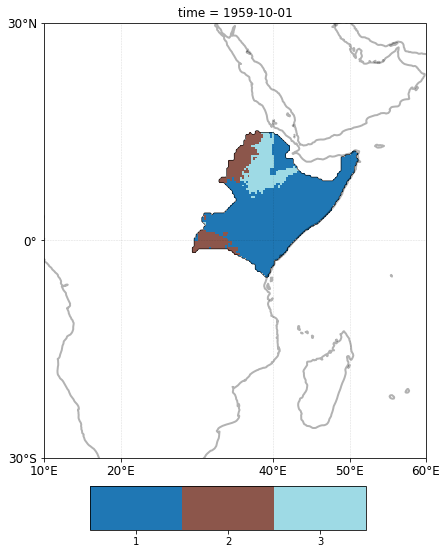

In [49]:
tp_hoa_binary = cl.binary_occurences_quantile(tp_hoa, 66)

xrclustered, algorithm = cl.skclustering(tp_hoa_binary, spatial_mask=~np.isnan(hoa_mask), 
                                         clustermethodkey = 'AgglomerativeClustering',
                                         kwrgs = {'n_clusters': 3, 'affinity':'jaccard', 'linkage':'complete'},
                                         dimension='spatial')
plotting.plot_labels(xrclustered,   
                   kwrgs_plot={'size':8, 'cbar_vert':-0.1, 'mask_xr':~np.isnan(hoa_mask)} )

In [70]:
df_hoa['label']

12     69
19    115
36    206
41    231
Name: label, dtype: object

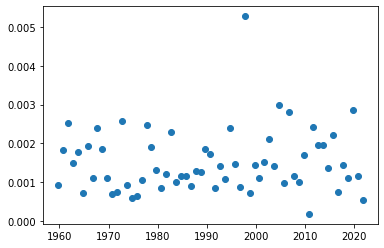

In [53]:
plt.plot_date(x=utils.pd.to_datetime(tp_somalia.time.values), y=tp_somalia)

In [54]:
df = tp_somalia.to_dataframe(name='tp_somalia')

<AxesSubplot:xlabel='time'>

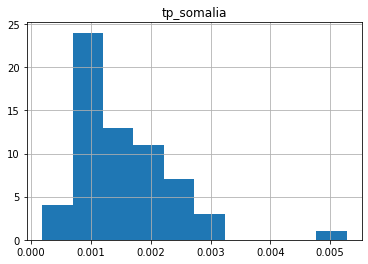

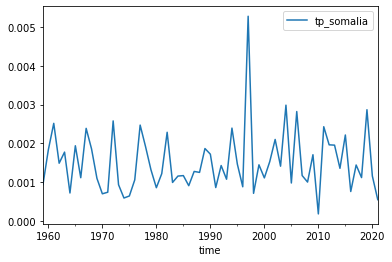

In [55]:
df.loc[df.index.month==10].hist() ; df.loc[df.index.month==10].plot()